In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
import pandas as pd

source_df = pd.read_csv("/content/Source.csv")
target_df = pd.read_csv("/content/Target.csv")

#IWKRR_Implementation by Ruibzhan

In [ ]:
# prompt: sklearn.linear_model.ridge

from sklearn import linear_model

In [ ]:
import warnings

import numpy as np

from cvxopt import matrix, solvers
solvers.options['show_progress'] = False
# Updated import for pairwise_kernels
from sklearn.metrics import pairwise_kernels
# Updated import for _solve_cholesky_kernel
from sklearn.linear_model._ridge import _solve_cholesky_kernel
import sklearn.utils

#================================
class InstanceKRR:
    """
    Attributes
    ----------
    dual_coef_ : array, shape = [n_samples] or [n_samples, n_targets]
        Representation of weight vector(s) in kernel space
    X_fit_ : {array-like, sparse matrix}, shape = [n_samples, n_features]
        Training data, which is also required for prediction. If
        kernel == "precomputed" this is instead the precomputed
        training matrix, shape = [n_samples, n_samples].
    """

    def __init__(self, lmbd = 1, kernel = 'rbf',gamma=None, degree=3, coef0=1,kernel_params=None):
        self.lmbd = lmbd
        self.kernel = kernel
        self.gamma = gamma
        self.degree = degree
        self.coef0 = coef0
        self.kernel_params = kernel_params

    def _get_kernel(self, X, Y = None, indicted_gamma = None):
        if callable(self.kernel):
            params = self.kernel_params or {}
        else:
            params = {'gamma': self.gamma,
                      'degree': self.degree,
                      'coef0': self.coef0}
        if indicted_gamma: # if not indicated, use self.gamma
            params['gamma'] = indicted_gamma
        return pairwise_kernels(X,Y,metric = self.kernel,filter_params = True, **params)

    def fit(self, X, y = None, sample_weight = None):
        X,y = sklearn.utils.check_X_y(X,y, accept_sparse = ('csr', "csc"), multi_output=True,
                                      y_numeric=True)
        n_samples, n_features = X.shape

        # sample weights
        K = self._get_kernel(X)
        lmbd = np.atleast_1d(self.lmbd)# why??
        one_alpha = (lmbd == lmbd[0]).all()

        ravel = False
        if len(y.shape) == 1:
            y = y.reshape(-1,1)
            ravel = True

        if one_alpha:
            K.flat[::n_samples+1] += lmbd[0] # Save memory
            try:
                self.dual_coef_ = np.linalg.solve(K,y)
            except np.linalg.LinAlgError:
                warnings.warn("Singular matrix in solving dual problem. Using least-squares solution instead.")
                self.dual_coef_ = np.linalg.lstsq(K,y)[0]
            K.flat[::n_samples+1] -= lmbd[0]

        else:
            warnings.warn("Multiple lambda values, check in later")

        if ravel:
            self.dual_coef_ = self.dual_coef_.ravel()

        self.X_fit_ = X
        self.y_fit_ = y
        self.n_source_sampels = n_samples

        return self

    def kRR_predict(self,x):
        sklearn.utils.validation.check_is_fitted(self,["X_fit_","y_fit_","dual_coef_"])
        k = self._get_kernel(x,self.X_fit_)
        y = np.dot(k,self.dual_coef_)
        return y

    def _get_D_matrix(self, Xaux, yaux, eta = 1):
        # a is the self.dual_coef
        Xy_source = np.hstack((self.X_fit_,self.y_fit_))
        Xy_aux = np.hstack((Xaux,yaux))
        self.E_mat = self._get_kernel(Xy_source,Xy_aux,indicted_gamma = eta)
        K_SAX = self._get_kernel(self.X_fit_,Xaux)
        Stacking = np.dot(self.dual_coef_.reshape(1,-1),K_SAX)
        Stacked = np.tile(Stacking,(self.n_source_sampels,1))
        self.D_mat = np.multiply(self.E_mat,Stacked)

        return self

    def Solve_alpha(self, Xaux, Yaux, eta = 1, lmbd2 = 1):
        sklearn.utils.validation.check_is_fitted(self,["X_fit_","dual_coef_","y_fit_"])
        Xaux,Yaux = sklearn.utils.check_X_y(Xaux,Yaux, accept_sparse = ('csr', "csc"), multi_output=True,
                                      y_numeric=True)
        if len(Yaux.shape) == 1:
            Yaux = Yaux.reshape(-1,1)

        self._get_D_matrix(Xaux, Yaux, eta = eta)
        D_mat = self.D_mat
        n_samples, n_features = D_mat.shape

        DD_mat = np.dot(D_mat, D_mat.T)
        #=== cvx.qp
        # J = ||y-D'*alphas||^2 + lmbd/2 * ||alphas||2
        DD_mat.flat[::n_samples+1] += lmbd2/2
        P = matrix(DD_mat)
        Q = matrix(np.dot(D_mat,Yaux)) # q is given in q'
        G = matrix(np.diag(-1*np.ones(n_samples)))
        h = matrix(np.zeros(n_samples).reshape(-1,1))
        self.alphas = np.array(solvers.qp(P,Q,G,h)['x'])

        self.n_aux_samples = Xaux.shape[0]
        self.X_aux_ = Xaux
        self.Y_aux_ = Yaux

        return self

    def predict(self,X):
        Weights_S = np.multiply(self.alphas.ravel(),np.sum(self.E_mat,axis = 1))
        Weights_all = np.hstack((np.ones(self.n_aux_samples) ,(Weights_S/np.max(Weights_S))))
        Ysp = np.vstack((self.Y_aux_, self.y_fit_))
        Xsp = np.vstack((self.X_aux_, self.X_fit_))
        KK = self._get_kernel(Xsp)
        Kx = self._get_kernel(Xsp,X)

        self.a_prediction = _solve_cholesky_kernel(KK,Ysp,self.lmbd,sample_weight=Weights_all)

        y_prediction = np.dot(Kx.T,self.a_prediction)

        return y_prediction

#Preparing Data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd


X_source = source_df[['LL', 'PL', 'PI', 'Moisture', 'Density']].values
y_source = source_df['USS'].values


target_features = ['LL', 'PL', 'PI', 'Moisture', 'Density']

if not all(feature in target_df.columns for feature in target_features):
    print("Warning: Not all expected target features found in target_df.")

    available_target_features = [f for f in target_features if f in target_df.columns]
    X_target = target_df[available_target_features].values

    if 'USS' in target_df.columns:
         y_target = target_df['USS'].values
    else:
         raise ValueError("Target column 'USS' not found in target_df.")
else:
    X_target = target_df[target_features].values
    y_target = target_df['USS'].values

Xa, Xt, ya, yt = train_test_split(
    X_target, y_target, test_size=0.2, random_state=42
)


scaler = StandardScaler()

X_source_scaled = scaler.fit_transform(X_source)
Xa_scaled = scaler.transform(Xa)
Xt_scaled = scaler.transform(Xt)


if not np.isfinite(X_source_scaled).all():
    print("Error: X_source_scaled contains non-finite values (NaN or Inf).")


if not np.isfinite(Xa_scaled).all():
    print("Error: Xa_scaled contains non-finite values (NaN or Inf).")


if not np.isfinite(Xt_scaled).all():
    print("Error: Xt_scaled contains non-finite values (NaN or Inf).")


# Training model with Gridsearch

In [ ]:
from sklearn.metrics import r2_score
import numpy as np

# Define search grids
lambda_values = np.logspace(-3, 1, 30)     # Regularization parameter
gamma_values = np.logspace(-3, 1, 30)      # RBF kernel width

# Tracking best result
best_lambda = None
best_gamma = None
best_r2 = -np.inf
best_model = None
best_predictions = None

# Grid search with RBF kernel
for lmbd in lambda_values:
    for gamma in gamma_values:
        model = InstanceKRR(
            lmbd=lmbd,
            gamma=gamma,
            kernel='rbf'  # Ensure RBF is explicitly set
        )

        try:
            model.fit(X_source_scaled, y_source)
            model.Solve_alpha(Xa_scaled, ya)
            y_pred = model.predict(Xt_scaled)

            r2 = r2_score(yt, y_pred)

            if r2 > best_r2:
                best_r2 = r2
                best_lambda = lmbd
                best_gamma = gamma
                best_model = model
                best_predictions = y_pred

            print(f"λ={lmbd:.4f}, γ={gamma:.4f} | R² = {r2:.4f}")

        except Exception as e:
            print(f"λ={lmbd:.4f}, γ={gamma:.4f} failed: {e}")

# Print best result
print("\nBest Configuration (RBF Kernel):")
print(f"Lambda (λ): {best_lambda}")
print(f"Gamma (γ): {best_gamma}")
print(f"Best R² on Test Target Data: {round(best_r2, 4)}")


λ=0.0010, γ=0.0010 | R² = 0.8616
λ=0.0010, γ=0.0014 | R² = 0.8628
λ=0.0010, γ=0.0019 | R² = 0.8633
λ=0.0010, γ=0.0026 | R² = 0.8626
λ=0.0010, γ=0.0036 | R² = 0.8599
λ=0.0010, γ=0.0049 | R² = 0.8510
λ=0.0010, γ=0.0067 | R² = 0.8512
λ=0.0010, γ=0.0092 | R² = 0.8512
λ=0.0010, γ=0.0127 | R² = 0.8564
λ=0.0010, γ=0.0174 | R² = 0.8614
λ=0.0010, γ=0.0240 | R² = 0.8654
λ=0.0010, γ=0.0329 | R² = 0.8686
λ=0.0010, γ=0.0452 | R² = 0.8696
λ=0.0010, γ=0.0621 | R² = 0.8665
λ=0.0010, γ=0.0853 | R² = 0.8393
λ=0.0010, γ=0.1172 | R² = 0.8054
λ=0.0010, γ=0.1610 | R² = 0.7581
λ=0.0010, γ=0.2212 | R² = 0.7027
λ=0.0010, γ=0.3039 | R² = 0.5742
λ=0.0010, γ=0.4175 | R² = 0.3564
λ=0.0010, γ=0.5736 | R² = 0.1658
λ=0.0010, γ=0.7880 | R² = 0.1247
λ=0.0010, γ=1.0826 | R² = 0.1738
λ=0.0010, γ=1.4874 | R² = 0.2927
λ=0.0010, γ=2.0434 | R² = 0.3628
λ=0.0010, γ=2.8072 | R² = 0.3230
λ=0.0010, γ=3.8566 | R² = 0.1476
λ=0.0010, γ=5.2983 | R² = -0.1918
λ=0.0010, γ=7.2790 | R² = -0.7169
λ=0.0010, γ=10.0000 | R² = -1.4191
λ=0.00

In [ ]:
# hyperparameters of the best model found
if best_model is not None:
    print("\nHyperparameters of the Best Model:")
    print("Lambda (lmbd):", best_model.lmbd)
    print("Kernel:", best_model.kernel)
    print("Gamma:", best_model.gamma)
    print("Degree:", best_model.degree)
    print("Coef0:", best_model.coef0)
    print("Kernel Params:", best_model.kernel_params)
else:
    print("\nNo best model found.")




Hyperparameters of the Best Model:
Lambda (lmbd): 0.3039195382313198
Kernel: rbf
Gamma: 0.16102620275609392
Degree: 3
Coef0: 1
Kernel Params: None


In [ ]:
# prompt: in the evaluation results include r2, rmse, mse, mae and mape (%)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np # Ensure numpy is imported for calculations

# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

# Evaluate KRR on source data
mse_source = mean_squared_error(y_source, yhat_source_plot)
rmse_source = np.sqrt(mse_source)
mae_source = mean_absolute_error(y_source, yhat_source_plot)
mape_source = mean_absolute_percentage_error(y_source, yhat_source_plot)
r2_source = r2_score(y_source, yhat_source_plot)

print(f"Evaluation on Source Data:")
print(f"R2: {r2_source:.4f}")
print(f"RMSE: {rmse_source:.4f}")
print(f"MSE: {mse_source:.4f}")
print(f"MAE: {mae_source:.4f}")
print(f"MAPE: {mape_source:.2f}%")
print("-" * 20)




# Evaluate Instance-weighted KRR on the train part of target data (auxiliary)
# Note: Evaluating on the training data doesn't reflect generalization performance
# but can be useful for understanding model fit to the training set.
mse_target_train = mean_squared_error(ya, y_prd_aux_plot)
rmse_target_train = np.sqrt(mse_target_train)
mae_target_train = mean_absolute_error(ya, y_prd_aux_plot)
mape_target_train = mean_absolute_percentage_error(ya, y_prd_aux_plot)
r2_target_train = r2_score(ya, y_prd_aux_plot)

print(f"Evaluation on Train Target Data (Auxiliary - Instance-weighted KRR):")
print(f"R2: {r2_target_train:.4f}")
print(f"RMSE: {rmse_target_train:.4f}")
print(f"MSE: {mse_target_train:.4f}")
print(f"MAE: {mae_target_train:.4f}")
print(f"MAPE: {mape_target_train:.2f}%")


# Evaluate Instance-weighted KRR on the test part of target data
mse_target_test = mean_squared_error(yt, y_prd_test_eval)
rmse_target_test = np.sqrt(mse_target_test)
mae_target_test = mean_absolute_error(yt, y_prd_test_eval)
mape_target_test = mean_absolute_percentage_error(yt, y_prd_test_eval)
r2_target_test = r2_score(yt, y_prd_test_eval)

print(f"Evaluation on Test Target Data (Instance-weighted KRR):")
print(f"R2: {r2_target_test:.4f}")
print(f"RMSE: {rmse_target_test:.4f}")
print(f"MSE: {mse_target_test:.4f}")
print(f"MAE: {mae_target_test:.4f}")
print(f"MAPE: {mape_target_test:.2f}%")
print("-" * 20)


Evaluation on Source Data:
R2: 0.7502
RMSE: 2.7754
MSE: 7.7027
MAE: 1.1966
MAPE: 96.60%
--------------------
Evaluation on Train Target Data (Auxiliary - Instance-weighted KRR):
R2: 0.8864
RMSE: 7.1402
MSE: 50.9830
MAE: 5.3545
MAPE: 70.18%
Evaluation on Test Target Data (Instance-weighted KRR):
R2: 0.8763
RMSE: 6.8873
MSE: 47.4342
MAE: 5.4600
MAPE: 51.98%
--------------------


#ablation with CI

#ABLATION STUDY

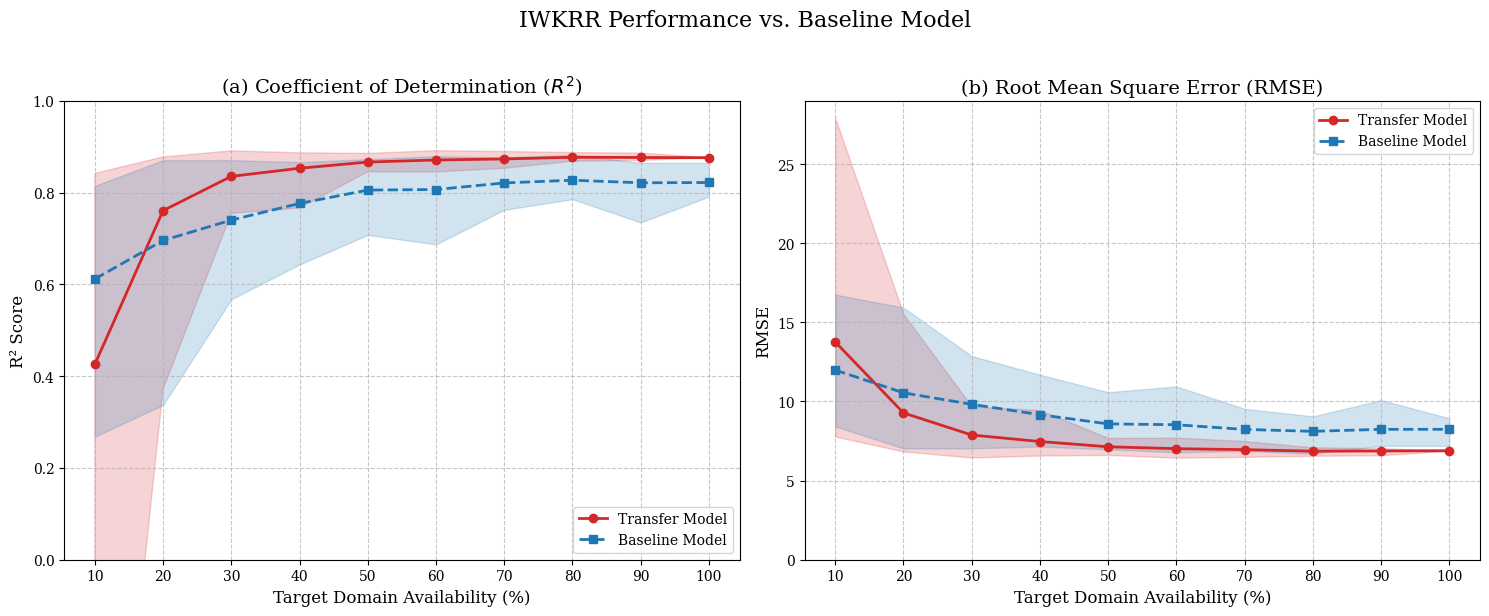

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

# ==============================================================================
# Font Configuration for Times New Roman
# This is a robust way to set the font, as it tells Matplotlib to use the
# 'serif' family, with 'Times New Roman' as the preferred font.
# ==============================================================================
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

# Split full target data into fixed test set and pool for ablation
X_target = target_df[['LL', 'PL', 'PI', 'Moisture', 'Density']].values
y_target = target_df['USS'].values
Xa_full, Xt, ya_full, yt = train_test_split(X_target, y_target, test_size=0.2, random_state=42)

# Scale source and target
scaler = StandardScaler()
X_source_scaled = scaler.fit_transform(X_source)
Xa_full_scaled = scaler.transform(Xa_full)
Xt_scaled = scaler.transform(Xt)

# Define IWKRR parameter grid (as provided)
best_lmbd = 0.3039195382313198
best_gamma = 0.16102620275609392

# Define AdaBoost.R2 parameters (as provided)
adaboost_params = {
    'estimator': DecisionTreeRegressor(max_depth=2),
    'n_estimators': 10,
    'random_state': 42
}

# Ablation study setup
target_percents = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
n_runs = 40  # Number of times to repeat the random splitting for stability

# Arrays to store all R² and RMSE scores from each run
r2_scores_iwkrr_all = np.zeros((n_runs, len(target_percents)))
r2_scores_adaboost_all = np.zeros((n_runs, len(target_percents)))
rmse_scores_iwkrr_all = np.zeros((n_runs, len(target_percents)))
rmse_scores_adaboost_all = np.zeros((n_runs, len(target_percents)))

# Main loop for repeated runs
for i in range(n_runs):
    # Shuffle the ablation pool data at the beginning of each run
    shuffled_indices = np.random.permutation(len(Xa_full_scaled))
    Xa_full_shuffled = Xa_full_scaled[shuffled_indices]
    ya_full_shuffled = ya_full[shuffled_indices]

    for j, perc in enumerate(target_percents):
        n_samples = int(len(Xa_full_shuffled) * perc)
        if n_samples < 2:
            continue

        Xa_sub = Xa_full_shuffled[:n_samples]
        ya_sub = ya_full_shuffled[:n_samples]

        # IWKRR Model
        model_iwkrr = InstanceKRR(lmbd=best_lmbd, gamma=best_gamma, kernel='rbf')
        model_iwkrr.fit(X_source_scaled, y_source)
        model_iwkrr.Solve_alpha(Xa_sub, ya_sub)
        y_pred_iwkrr = model_iwkrr.predict(Xt_scaled)
        r2_iwkrr = r2_score(yt, y_pred_iwkrr)
        rmse_iwkrr = np.sqrt(mean_squared_error(yt, y_pred_iwkrr))
        r2_scores_iwkrr_all[i, j] = r2_iwkrr
        rmse_scores_iwkrr_all[i, j] = rmse_iwkrr

        # AdaBoost.R2 (Baseline) Model
        model_adaboost = AdaBoostRegressor(**adaboost_params)
        model_adaboost.fit(Xa_sub, ya_sub)
        y_pred_adaboost = model_adaboost.predict(Xt_scaled)
        r2_adaboost = r2_score(yt, y_pred_adaboost)
        rmse_adaboost = np.sqrt(mean_squared_error(yt, y_pred_adaboost))
        r2_scores_adaboost_all[i, j] = r2_adaboost
        rmse_scores_adaboost_all[i, j] = rmse_adaboost

# Calculate mean and 90% confidence interval for each percentage
# R² scores
mean_r2_iwkrr = np.mean(r2_scores_iwkrr_all, axis=0)
ci_r2_iwkrr_low = np.percentile(r2_scores_iwkrr_all, 2.5, axis=0)
ci_r2_iwkrr_high = np.percentile(r2_scores_iwkrr_all, 97.5, axis=0)

mean_r2_adaboost = np.mean(r2_scores_adaboost_all, axis=0)
ci_r2_adaboost_low = np.percentile(r2_scores_adaboost_all, 2.5, axis=0)
ci_r2_adaboost_high = np.percentile(r2_scores_adaboost_all, 97.5, axis=0)

# RMSE scores
mean_rmse_iwkrr = np.mean(rmse_scores_iwkrr_all, axis=0)
ci_rmse_iwkrr_low = np.percentile(rmse_scores_iwkrr_all, 2.5, axis=0)
ci_rmse_iwkrr_high = np.percentile(rmse_scores_iwkrr_all, 97.5, axis=0)

mean_rmse_adaboost = np.mean(rmse_scores_adaboost_all, axis=0)
ci_rmse_adaboost_low = np.percentile(rmse_scores_adaboost_all, 2.5, axis=0)
ci_rmse_adaboost_high = np.percentile(rmse_scores_adaboost_all, 97.5, axis=0)

# Plotting the results with two subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
target_percents_plot = np.array(target_percents) * 100

# Subplot 1: R² Score
axes[0].plot(target_percents_plot, mean_r2_iwkrr, 'o-', label="Transfer Model", color='tab:red', linewidth=2)
axes[0].fill_between(target_percents_plot, ci_r2_iwkrr_low, ci_r2_iwkrr_high, color='tab:red', alpha=0.2)
axes[0].plot(target_percents_plot, mean_r2_adaboost, 's--', label="Baseline Model", color='tab:blue', linewidth=2)
axes[0].fill_between(target_percents_plot, ci_r2_adaboost_low, ci_r2_adaboost_high, color='tab:blue', alpha=0.2)

axes[0].set_xlabel("Target Domain Availability (%)", fontsize=12)
axes[0].set_ylabel("R² Score", fontsize=12)
axes[0].set_title("(a) Coefficient of Determination ($R^2$)", fontsize=14)
axes[0].grid(True, linestyle='--', alpha=0.7)
axes[0].set_xticks(target_percents_plot)
axes[0].set_ylim(0, 1.0)
axes[0].legend()

# Subplot 2: RMSE
axes[1].plot(target_percents_plot, mean_rmse_iwkrr, 'o-', label="Transfer Model", color='tab:red', linewidth=2)
axes[1].fill_between(target_percents_plot, ci_rmse_iwkrr_low, ci_rmse_iwkrr_high, color='tab:red', alpha=0.2)
axes[1].plot(target_percents_plot, mean_rmse_adaboost, 's--', label="Baseline Model", color='tab:blue', linewidth=2)
axes[1].fill_between(target_percents_plot, ci_rmse_adaboost_low, ci_rmse_adaboost_high, color='tab:blue', alpha=0.2)

axes[1].set_xlabel("Target Domain Availability (%)", fontsize=12)
axes[1].set_ylabel("RMSE", fontsize=12)
axes[1].set_title("(b) Root Mean Square Error (RMSE)", fontsize=14)
axes[1].grid(True, linestyle='--', alpha=0.7)
axes[1].set_xticks(target_percents_plot)
axes[1].set_ylim(bottom=0)
axes[1].legend()

plt.suptitle("IWKRR Performance vs. Baseline Model", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

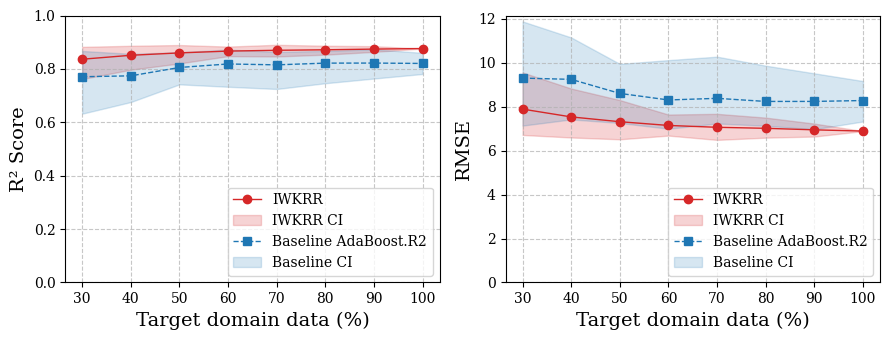

In [ ]:
# --- Visualization with legend at bottom-right and CI for IWKRR ---
fig, axes = plt.subplots(1, 2, figsize=(9, 3.5))
target_percents_plot = np.array(target_percents) * 100

# -------------------- R² Plot --------------------
line_iwkrr, = axes[0].plot(target_percents_plot, mean_r2_iwkrr, 'o-', color='tab:red', linewidth=1)
ci_iwkrr = axes[0].fill_between(target_percents_plot, ci_r2_iwkrr_low, ci_r2_iwkrr_high, color='tab:red', alpha=0.2)

line_adaboost, = axes[0].plot(target_percents_plot, mean_r2_adaboost, 's--', color='tab:blue', linewidth=1)
ci_adaboost = axes[0].fill_between(target_percents_plot, ci_r2_adaboost_low, ci_r2_adaboost_high, color='tab:blue', alpha=0.18)

axes[0].set_xlabel("Target domain data (%)", fontsize=14)
axes[0].set_ylabel("R² Score", fontsize=14)
#axes[0].set_title("(a) Coefficient of Determination ($R^2$)", fontsize=14)
axes[0].grid(True, linestyle='--', alpha=0.7)
axes[0].set_xticks(target_percents_plot)
axes[0].set_ylim(0, 1.0)
axes[0].legend(
    [line_iwkrr, ci_iwkrr, line_adaboost, ci_adaboost],
    ["IWKRR", "IWKRR CI", "Baseline AdaBoost.R2", "Baseline CI"],
    loc='lower right', fontsize=10
)

# -------------------- RMSE Plot --------------------
line_iwkrr_rmse, = axes[1].plot(target_percents_plot, mean_rmse_iwkrr, 'o-', color='tab:red', linewidth=1)
ci_iwkrr_rmse = axes[1].fill_between(target_percents_plot, ci_rmse_iwkrr_low, ci_rmse_iwkrr_high, color='tab:red', alpha=0.2)

line_adaboost_rmse, = axes[1].plot(target_percents_plot, mean_rmse_adaboost, 's--', color='tab:blue', linewidth=1)
ci_adaboost_rmse = axes[1].fill_between(target_percents_plot, ci_rmse_adaboost_low, ci_rmse_adaboost_high, color='tab:blue', alpha=0.18)

axes[1].set_xlabel("Target domain data (%)", fontsize=14)
axes[1].set_ylabel("RMSE", fontsize=14)
#axes[1].set_title("(b) Root Mean Square Error (RMSE)", fontsize=14)
axes[1].grid(True, linestyle='--', alpha=0.7)
axes[1].set_xticks(target_percents_plot)
axes[1].set_ylim(bottom=0)
axes[1].legend(
    [line_iwkrr_rmse, ci_iwkrr_rmse, line_adaboost_rmse, ci_adaboost_rmse],
    ["IWKRR", "IWKRR CI", "Baseline AdaBoost.R2", "Baseline CI"],
    loc='lower right', fontsize=10
)

#plt.suptitle("IWKRR Performance vs. Baseline Model", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


In [ ]:
fig.savefig('IWKRR vs Baseline ablation v2.svg', format='svg', dpi=1200)

#SHAP ANALYSIS

  0%|          | 0/27 [00:00<?, ?it/s]

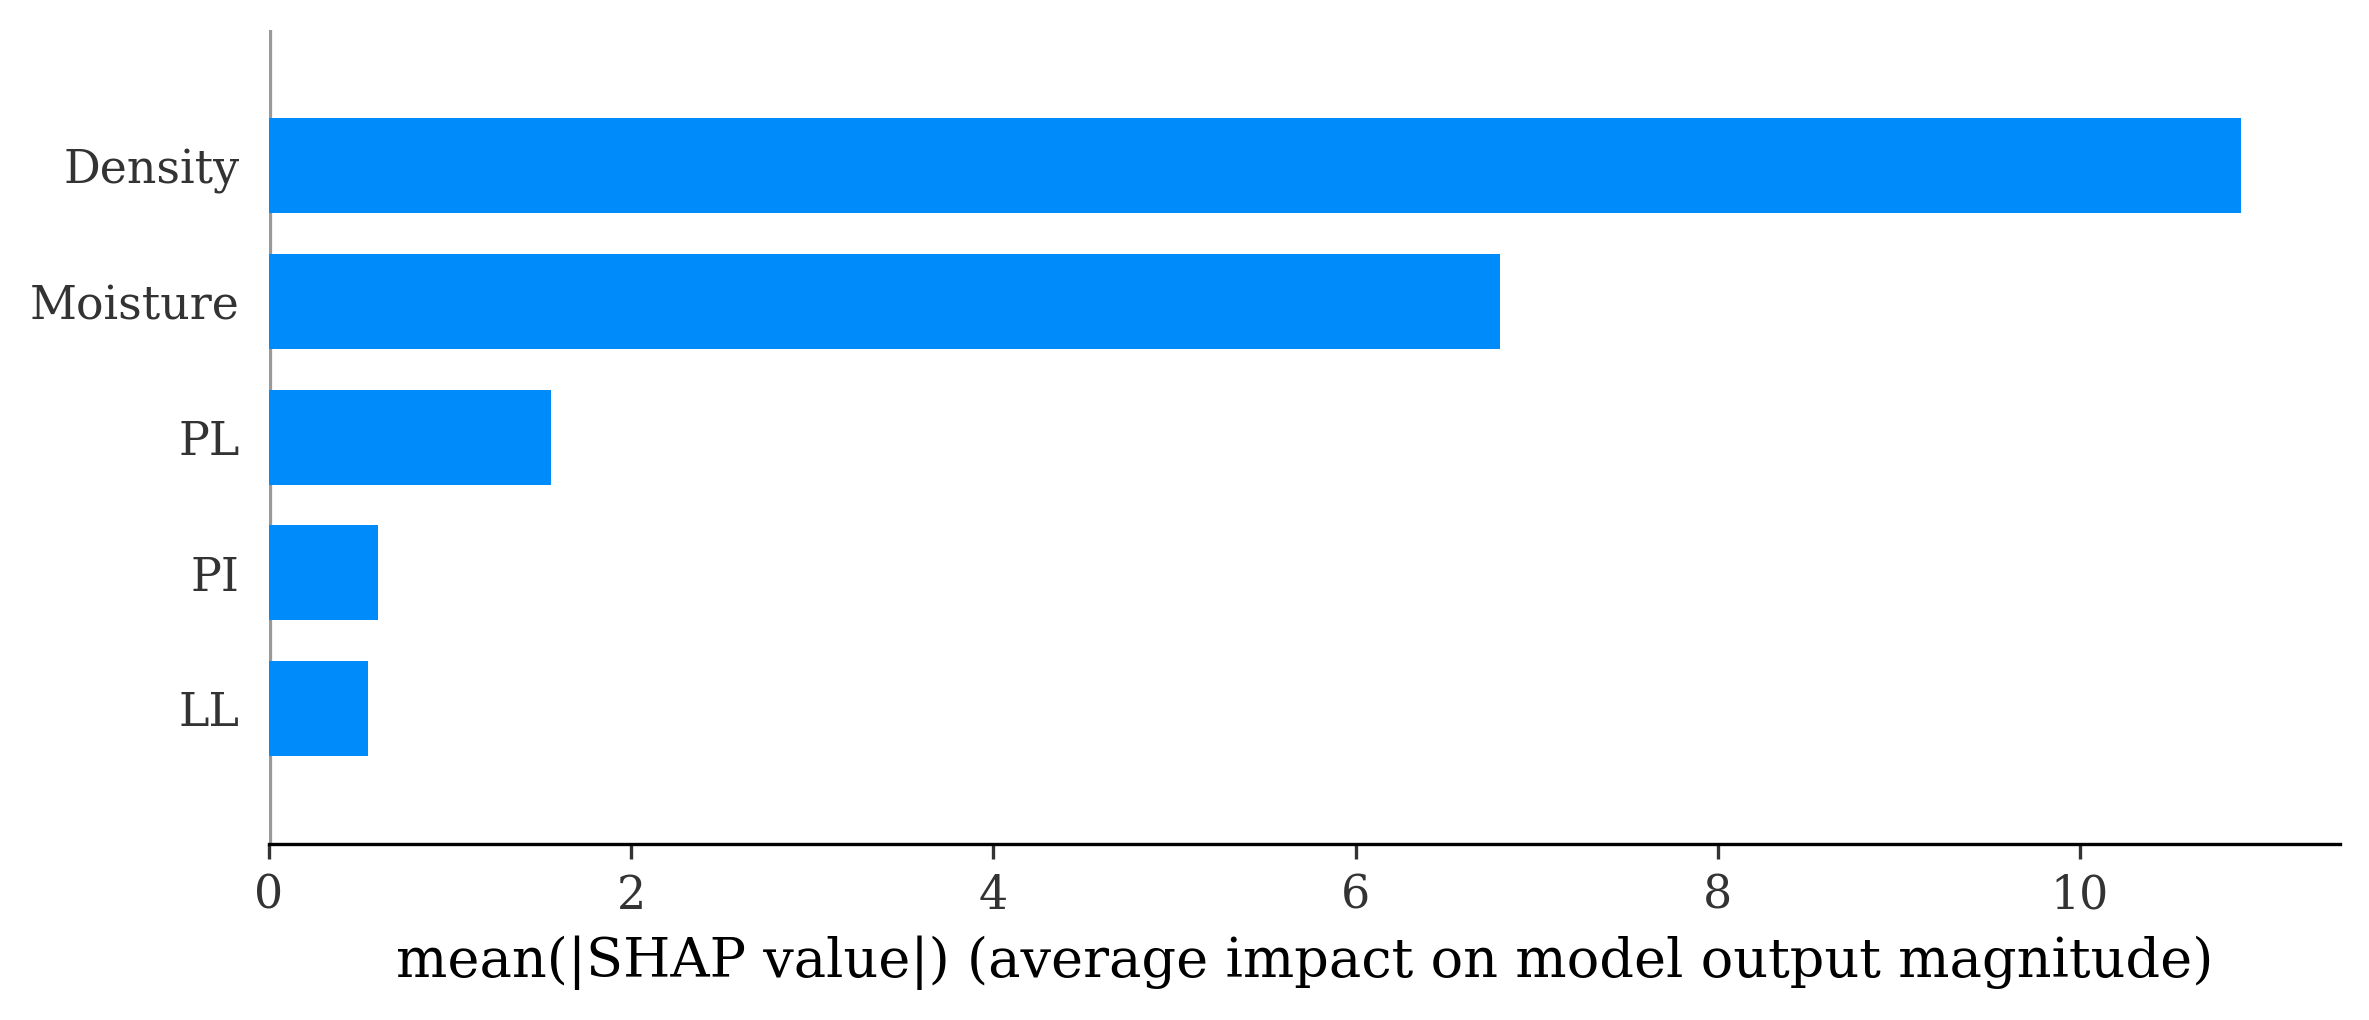

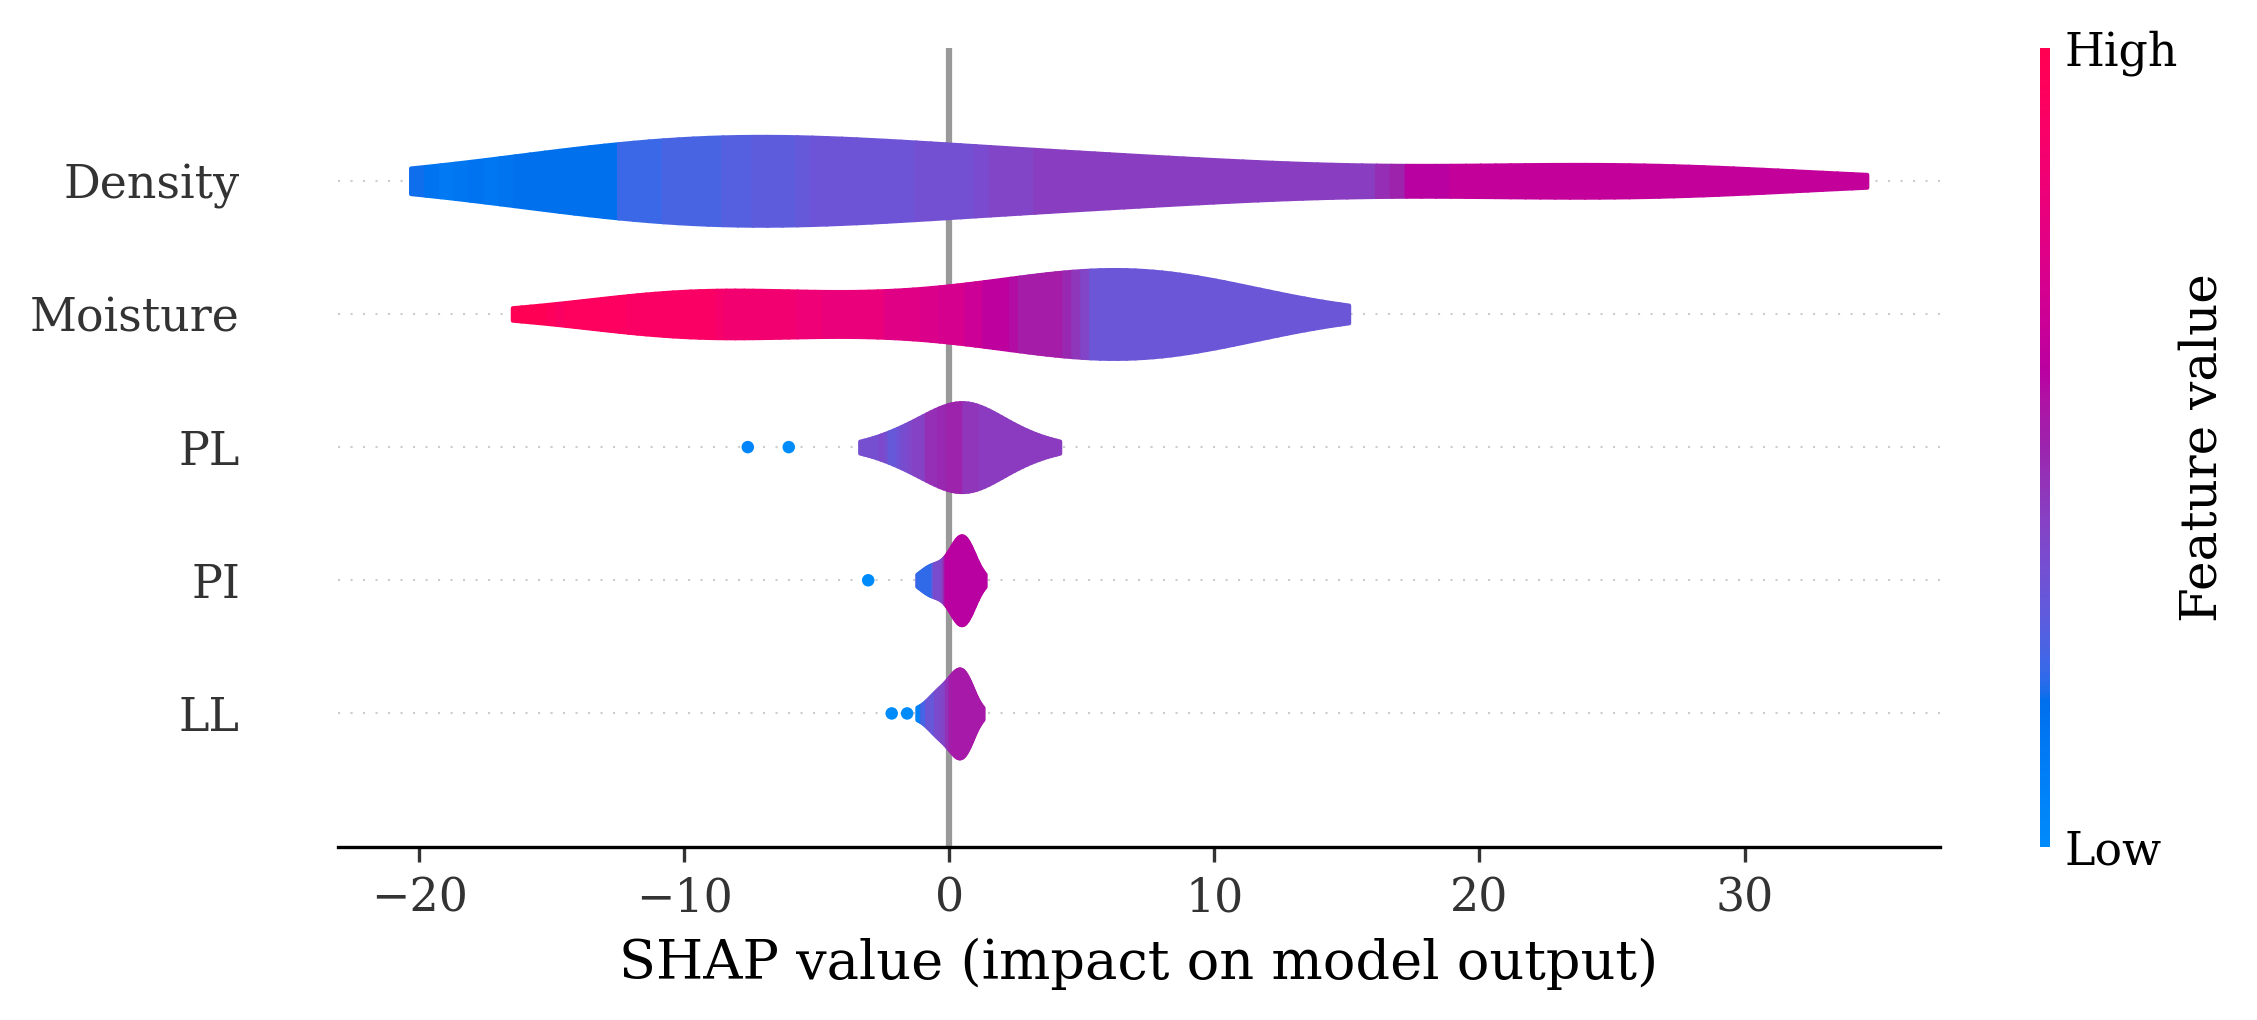

In [ ]:
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt

# =========================================
# Font Configuration (Times New Roman)
# =========================================
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

# ==== Step 1: Set hyperparameters and train IWKRR model ====
best_lambda = 0.3039195382313198
best_gamma = 0.16102620275609392

iwkrr_model = InstanceKRR(
    lmbd=best_lambda,
    gamma=best_gamma,
    kernel='rbf'
)

# Fit using source domain and solve using auxiliary
iwkrr_model.fit(X_source_scaled, y_source)
iwkrr_model.Solve_alpha(Xa_scaled, ya)

# Predict on target test set
y_pred_iwkrr = iwkrr_model.predict(Xt_scaled)

# ==== Step 2: Prepare SHAP data ====
feature_names = ['LL', 'PL', 'PI', 'Moisture', 'Density']
X_df = pd.DataFrame(Xt_scaled, columns=feature_names)

# Use background sample for KernelExplainer
background = shap.utils.sample(Xa_scaled, 50)
background_df = pd.DataFrame(background, columns=feature_names)

# Prediction function
def predict_fn(X):
    return iwkrr_model.predict(X).ravel()

# Initialize SHAP explainer
explainer = shap.KernelExplainer(predict_fn, background_df)

# Compute SHAP values
shap_values = explainer.shap_values(X_df)

# ==== Step 3a: SHAP Bar Plot ====
plt.figure(figsize=(6, 2.5), dpi=300)
shap.summary_plot(
    shap_values,
    features=X_df,
    feature_names=feature_names,
    plot_type="bar",
    show=False
)
#plt.title("Feature Importance (SHAP) – Bar", fontsize=11)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.savefig("shap_bar_iwkrr.svg", format="svg", dpi=1200, bbox_inches='tight')
plt.show()

# ==== Step 3b: SHAP Violin Plot ====
plt.figure(figsize=(6, 2.5), dpi=300)
shap.summary_plot(
    shap_values,
    features=X_df,
    feature_names=feature_names,
    plot_type="violin",
    show=False
)
#plt.title("Feature Importance (SHAP) – Violin", fontsize=11)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.savefig("shap_violin_iwkrr.svg", format="svg", dpi=1200, bbox_inches='tight')
plt.show()


In [ ]:
plt.savefig("shap_side_by_side_iwkrr.jpeg", dpi=300, bbox_inches='tight')